<a href="https://colab.research.google.com/github/qmeng222/CNN/blob/main/RNN/sine_wave_extrapolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Task:

- Develop an RNN model for predicting a data sequence generated by the sine function x = sin(t + cos(t)), where 't' varies within the range from 0 to 30π.
- Predict the next time point data value.
- Test on new data:
  - with different frequency: x = sin(t + cos(t)), where 't' varies within the range from 0 to 10π.
  - with diffrent funciton: x = sin(t + sin(t)), where 't' varies within the range from 0 to 30π.

In [45]:
import torch
import torch.nn as nn
import numpy as np

import sys # for printing out status reports

import matplotlib.pyplot as plt
import matplotlib_inline as inl
inl.backend_inline.set_matplotlib_formats("svg")

# Create temporal sequence data:

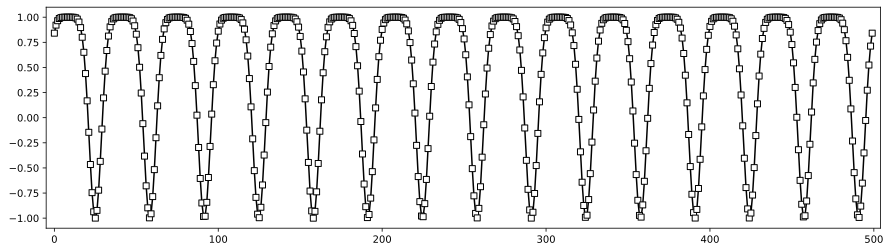

In [46]:
N = 500

# sine function
time = torch.linspace(0,30*np.pi,N)
data = torch.sin(time+torch.cos(time))

# plot the sine function
plt.figure(figsize=(15,4))
plt.plot(data,'ks-',markerfacecolor='w')
plt.xlim([-5,N+4])
plt.show()

# Create a class for the DL model:

In [47]:
class rnnnet(nn.Module):
  def __init__(self):
    super().__init__()

    # RNN Layer
    self.rnn = nn.RNN(input_size,num_hidden,num_layers)

    # linear layer for output
    self.out = nn.Linear(num_hidden,1)

  def forward(self, x, h):
    # pass through the RNN layer
    y,hidden = self.rnn(x,h)

    # pass through the linear layer (output)
    y = self.out(y)

    return y,hidden.detach() # detach a tensor from the computation graph

In [48]:
# network parameters
input_size =  1 # "channels" of data
num_hidden =  9 # number of units in hidden layers
num_layers =  1 # depth of model (number of "stacks" of hidden layers)
seqlength  = 30 # number of datapoints used for learning in each segment
batchsize  =  1

# create an instance of the model
net = rnnnet()

# generate fake data & pass the fake data through the above model instance
X = torch.rand(seqlength,batchsize,input_size)
y,h = net(X,None) # None is for empty hidden state input
print(X.shape)
print(y.shape)
print(h.shape)

torch.Size([30, 1, 1])
torch.Size([30, 1, 1])
torch.Size([1, 1, 9])


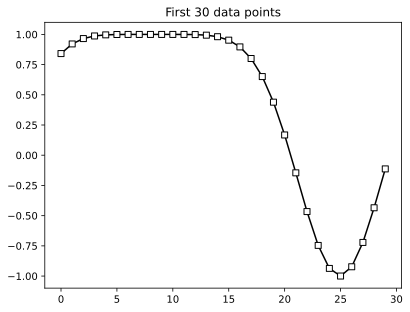

In [49]:
# plot the first 30 data points (seqlength = 30):

plt.plot(data[:seqlength],'ks-',markerfacecolor='w')
plt.title(f'First {seqlength} data points')
plt.show()

👆These data points in a seqlenght is not quite enough to learn the sine characteristic.

In [50]:
# test the model with a seqlength of data
somedata = data[:seqlength].view(seqlength,1,1)
y = net(somedata,None)

# grab the final predicted value from the output (first element of tuple output of net)
finalValue = y[0][-1]

lossfun = nn.MSELoss() # for numerical prediction
lossfun(finalValue,data[seqlength].view(1,1)) # predicted value vs. the next value (true value)

tensor(0.0502, grad_fn=<MseLossBackward0>)

# Train the model:

In [51]:
numepochs = 30

# create a new instance of the model & optimizer
net = rnnnet()
optimizer = torch.optim.SGD(net.parameters(),lr=.001)

# initialize losses
losses = np.zeros(numepochs)
signaccuracy = np.zeros(numepochs)

# loop over epochs
for epochi in range(numepochs):
  seglosses = []
  segacc    = []
  hiddenstate = None

  # loop over data segments
  for timei in range(N-seqlength):
    # grab a snippet of data
    X = data[timei:timei+seqlength].view(seqlength,1,1)
    y = data[timei+seqlength].view(1,1)

    # forward pass and loss
    yHat,hiddenstate = net(X,hiddenstate)
    finalValue = yHat[-1]
    loss = lossfun(finalValue,y) # compare final value of output

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # loss from this segment
    seglosses.append(loss.item())

  # average losses from this epoch
  losses[epochi] = np.mean(seglosses)

  msg = f'Finished epoch {epochi+1}/{numepochs}'
  sys.stdout.write('\r' + msg)

Finished epoch 30/30

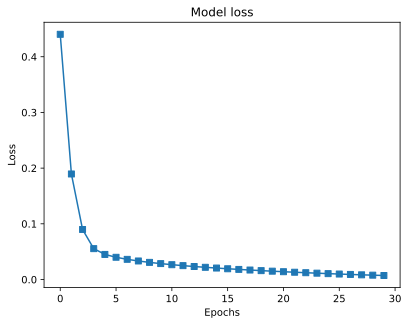

In [52]:
# check how the model performed:

plt.plot(losses,'s-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model loss')

plt.show()

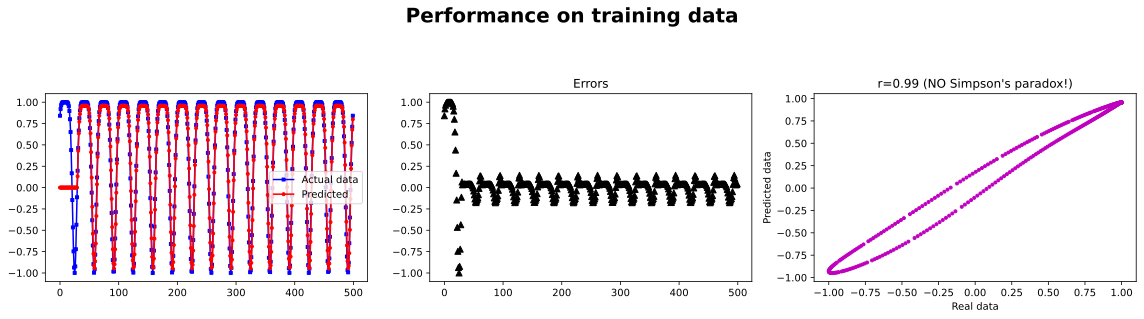

In [53]:
# test the network with the actual data:

h = np.zeros((N,num_hidden))

yHat = np.zeros(N)
hh = None

# loop over data segments
for timei in range(N-seqlength):
  # grab a data segment
  X = data[timei:timei+seqlength].view(seqlength,1,1)

  # forward pass and loss
  yy,hh = net(X,hh)
  yHat[timei+seqlength] = yy[-1]
  h[timei+seqlength,:] = hh.detach()

# visualize
fig,ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(data,'bs-',label='Actual data',markersize=3)
ax[0].plot(yHat,'ro-',label='Predicted',markersize=3)
ax[0].set_ylim([-1.1,1.1])
ax[0].legend()

ax[1].plot(data-yHat,'k^')
ax[1].set_ylim([-1.1,1.1])
ax[1].set_title('Errors')

ax[2].plot(data[seqlength:],yHat[seqlength:],'mo',markersize=3)
ax[2].set_xlabel('Real data')
ax[2].set_ylabel('Predicted data')
r = np.corrcoef(data[seqlength:],yHat[seqlength:])
ax[2].set_title(f"r={r[0,1]:.2f} (NO Simpson's paradox!)")

plt.suptitle('Performance on training data',fontweight='bold',fontsize=20,y=1.1)
plt.tight_layout()
plt.show()

👆 The predicted data look remarkably close to the actual data.

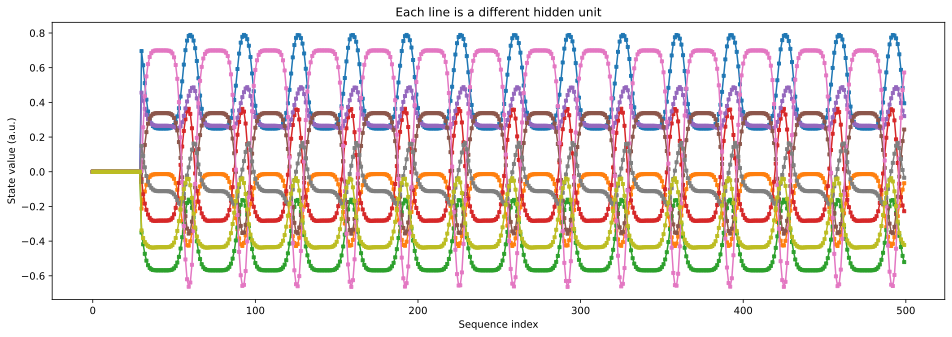

In [54]:
# show the hidden "states" (units activations)
plt.figure(figsize=(16,5))

plt.plot(h,'s-',markersize=3)
plt.xlabel('Sequence index')
plt.ylabel('State value (a.u.)')
plt.title('Each line is a different hidden unit')
plt.show()

👆None of them look exactly like our original data, but they all look kind of like the original data.

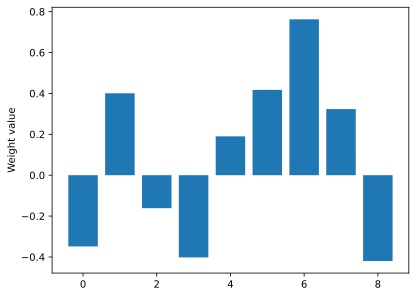

In [55]:
# plot the weights for the input->hidden layers
plt.bar(range(num_hidden),net.rnn.weight_ih_l0.detach())
plt.ylabel('Weight value')
plt.show()

# Test with new data of diff frequency:

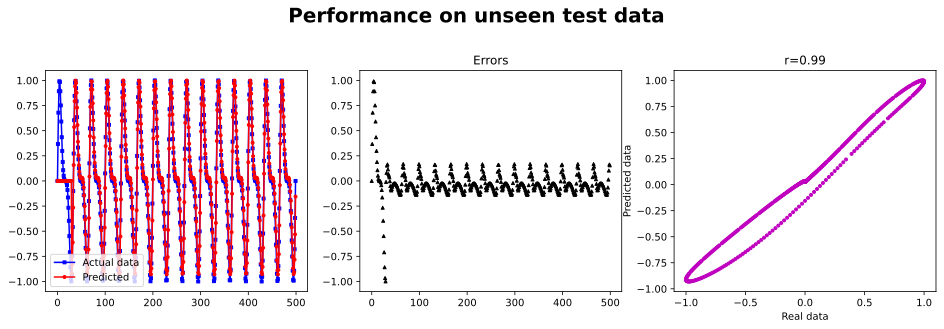

In [56]:
## Create new data (orange case: different frequency)
time = torch.linspace(0,10*np.pi,N)
newdata = torch.sin(time+torch.cos(time))

# Create new data (red case: different function)
time = torch.linspace(0,30*np.pi,N)
newdata = torch.sin(time+torch.sin(time))



# loop over time and predict each subsequent value
yHat = np.zeros(N)
h = None
for timei in range(N-seqlength):

  # grab a snippet of data
  X = newdata[timei:timei+seqlength].view(seqlength,1,1)

  # forward pass and loss (don't need hidden states here)
  yy,h = net(X,h)
  yHat[timei+seqlength] = yy[-1]


# plotting
fig,ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(newdata,'bs-',label='Actual data',markersize=3)
ax[0].plot(yHat,'ro-',label='Predicted',markersize=3)
ax[0].set_ylim([-1.1,1.1])
ax[0].legend()

ax[1].plot(newdata-yHat,'k^',markersize=3)
ax[1].set_ylim([-1.1,1.1])
ax[1].set_title('Errors')

ax[2].plot(newdata[seqlength:],yHat[seqlength:],'mo',markersize=3)
ax[2].set_xlabel('Real data')
ax[2].set_ylabel('Predicted data')
r = np.corrcoef(newdata[seqlength:],yHat[seqlength:])
ax[2].set_title(f"r={r[0,1]:.2f}")

plt.suptitle('Performance on unseen test data',fontweight='bold',fontsize=20,y=1.1)
plt.show()

# Long-term extrapolation is untrustworthy:

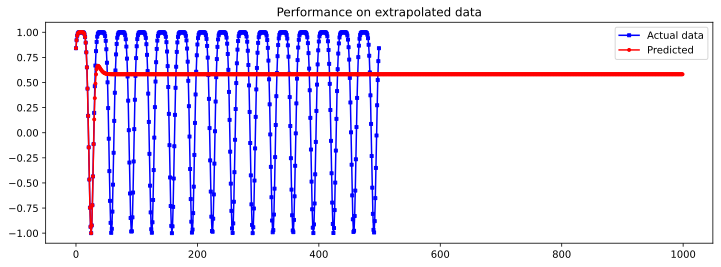

In [58]:
# using original data

# create a signal 2x as long
yHat = torch.zeros(2*N) # torch, not np!
yHat[:N] = data
h = None

for timei in range(2*N-seqlength):

  # grab a snippet of data
  X = yHat[timei:timei+seqlength].view(seqlength,1,1)

  # forward pass and loss
  yy,h = net(X,h)
  yHat[timei+seqlength] = yy[-1]

# convert back to np for plotting
yHat = yHat.detach()

# plotting
fig = plt.figure(figsize=(12,4))
plt.plot(data,'bs-',label='Actual data',markersize=3)
plt.plot(yHat,'ro-',label='Predicted',markersize=3)
plt.ylim([-1.1,1.1])
plt.legend()
plt.title('Performance on extrapolated data')
plt.show()